<a href="https://colab.research.google.com/github/kp713/Breast-Cancer-DDSM-Detection-Using-ResNet/blob/main/ResNet_for_Breast_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import roc_curve, auc
import sklearn.metrics
#import sklearn.metrics.roc_auc_score as roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score
#import sklearn.metrics.PrecisionRecallDisplay as precisionrecalldisplay


In [ ]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, valloss, model):

        score = -valloss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(valloss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(valloss, model)
            self.counter = 0

    def save_checkpoint(self, valloss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {valloss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = valloss

In [ ]:
#%%if running locally this step is not required
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#!unzip -uq "/content/drive/My Drive/CancerData40mag" -d "/content/drive/My Drive/40Mag"
#This code unzips the folder in google drive

In [ ]:
PATH_OF_DATA= '/content/drive/"My Drive"/40mag'   #this should be the file location
!ls {PATH_OF_DATA}


data_dir = '/content/drive/My Drive/40mag'
os.listdir('/content/drive/My Drive/40mag')

#In this block of code, we initialize the path of the data and set the data directory which will be used later.


test  train  val


['val', 'test', 'train']

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

#This code block checks the availability of a GPU for training the model.
#Here we're also setting the number of workers and the batch size for training on the gpu

CUDA is available!  Training on GPU ...
cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


100


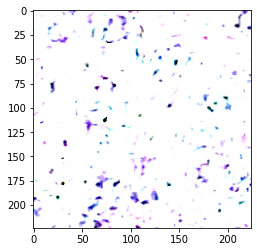

In [ ]:

#plt.imshow(image_datasets["train"][0][1].permute(1,2,0))
#plt.show
plt.imshow(image_datasets["train"][1][0].permute(1,2,0) )

print(len(image_datasets["test"]))

In [ ]:
#train_transforms = transforms.Compose([
 #       transforms.RandomRotation(30),
  #      transforms.RandomResizedCrop(224),
   #     #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    #    transforms.RandomHorizontalFlip(),
     #   transforms.ToTensor(),
      #  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    #])
#test_transforms = transforms.Compose([
 #       transforms.Resize(256),
 #       transforms.CenterCrop(224),
 #       transforms.ToTensor(),
 #       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  #  ])
train_transforms =transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms =transforms.Compose([
        transforms.Resize(224),
        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_transforms =transforms.Compose([
        transforms.Resize(224),
        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

#making the training, test and val sets and their dataloaders
train_set = datasets.ImageFolder(root="/content/drive/My Drive/40mag/train",transform=train_transforms)

train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=4)



test_set = datasets.ImageFolder(root="/content/drive/My Drive/40mag/test",transform=test_transforms)

test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=False,num_workers=4)

val_set = datasets.ImageFolder(root="/content/drive/My Drive/40mag/val",transform=val_transforms)

val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=True,num_workers=4)

In [ ]:

import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)
    
def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)
def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)









In [ ]:



#here we load the model we wrote the code for previously
model = resnet50(pretrained=False)

for param in model.parameters():
    param.requires_grad = False  #this is for whether we want to freeze our parameters or not

#this prints the model architecture
    print(model)




from collections import OrderedDict


#here we describe the structure of our classifier

classifier = nn.Sequential(OrderedDict([
                         ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.1)),
                          ('fc2', nn.Linear(512, 2)),
                           # ('relu', nn.ReLU()),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

#loading our classifier
model.fc = classifier
num_classes =2
valloss = []
trainloss =[]
valacc= []
trainacc = []
patience = 30 #threshold for early stopping

early_stopping = EarlyStopping(patience=patience, verbose=True) # if 30 times conescutively the loss does not decrease, the model stops training


#Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs,patience):
    since = time.time()
  
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  #training mode
            else:
                model.eval()   # eval mode

            running_loss = 0.0
            running_corrects = 0

            # loading data with dataloaders
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # initialize the parameter gradients
                optimizer.zero_grad()

                # forward prop
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward prop
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # calculating accuracy, loss
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == "train" :
                trainloss.append (epoch_loss) #storing each loss and accuracy of epoch in a list
                trainacc.append(epoch_acc)
            else :
                valloss.append (epoch_loss)
                valacc.append(epoch_acc)
        
    
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc)) #printing each loss and accuracy for both phases

            # this stores the model weights for the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                en = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
           
        early_stopping(valloss[epoch-1], model) #early stopping
        
        if early_stopping.early_stop:
              print("Early stopping")
              break
        model.load_state_dict(torch.load('checkpoint.pt')) #stores the checkpoint if early stopping is implemented


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))
    #print ("Best Model weights : ",best_model_wts)  #Optional code to print best model weights
    print (trainloss)
    print (valloss)

    #as accuracy gets stored as a tensor, we need to convert it to numpy for plotting a graph
    def tensortonumpy (acc) :
          x = acc
          nparray = []
   
          for i in range (en):
               a = x[i]
               a = a.cpu()
               b = a.numpy()
               c = float(b)
               nparray.append(c)
          return nparray
    val_acc = tensortonumpy(valacc)
    train_acc =tensortonumpy(trainacc)
    print(train_acc)
    print(val_acc)

    model.load_state_dict(best_model_wts) #loads weights of the best model

    #in this section we plot the graphs
    def mean(li): return sum(li)/len(li)
    plt.figure(figsize=(14, 4))
    plt.xlabel('training batch')
    plt.ylabel('loss')
    plt.plot([mean(trainloss[i:i+num_epochs]) for i in range(len(trainloss))])

    def mean(li): return sum(li)/len(li)
    plt.figure(figsize=(14, 4))
    plt.xlabel('validation batch')
    plt.ylabel('loss')
    plt.plot([mean(valloss[i:i+num_epochs]) for i in range(len(valloss))])

    def mean(li): return sum(li)/len(li)
    plt.figure(figsize=(14, 4))
    plt.xlabel('training batch')
    plt.ylabel('epoch')
    plt.plot(train_acc)

    def mean(li): return sum(li)/len(li)
    plt.figure(figsize=(14, 4))
    plt.xlabel('validation batch')
    plt.ylabel('epoch')
    plt.plot(val_acc)
    
    return model
    return trainloss,valloss
    return train_acc,val_acc

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
num_epochs =300
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
#optimizer = optim.Adam(model.fc.parameters(), lr=0.0001,weight_decay = 0.001)
optimizer = optim.SGD(model.fc.parameters(), lr = .0001, momentum=0.09, weight_decay = 0.01)
# Decay LR by a factor--  every -- epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs,patience)
torch.save(model_ft.state_dict(), "resnet50trial.pth")



In [ ]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  actuals = []
  probabilities = []
  predictions = []
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['test']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
    ##
   



    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            out    = output.cpu()
            prediction = out.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction) == 1)
            probabilities.extend(np.exp((out[:, 1])))
            
    return [i.item() for i in actuals], [i.item() for i in probabilities]
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['test'])))

actuals, class_probabilities = test(model, dataloaders,device)

fpr, tpr, _ = sklearn.metrics.roc_curve(actuals, class_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for digit=1 class Malignant')
plt.legend(loc="lower right")
plt.show()

def test_label_predictions(model, device, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model, device, test_loader)
print('Confusion matrix:')
print(confusion_matrix(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='micro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))

#test(model, dataloaders, device)